In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('cluster.csv', encoding= 'unicode_escape')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data Cleaning 

In [6]:
# checking for missing Values
df.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [7]:
# Droping the missing values(proble with filling CustomerID(There may same customer so filling with unique value is not possible))
df.dropna(subset='CustomerID',inplace=True)

In [8]:
# Droping irrelvent Columns
df.drop(['StockCode','Description','Country'],axis=1,inplace=True)

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
# Droping negative Quantity
df.drop(df[df['Quantity'] < 0].index, inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   Quantity     397924 non-null  int64  
 2   InvoiceDate  397924 non-null  object 
 3   UnitPrice    397924 non-null  float64
 4   CustomerID   397924 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.2+ MB


# Feature Construction

In [13]:
# Creating new Feature Recency, Frequency, Monetary for RFM analysis and customer segentation

In [14]:
# createing Monetary Column
df['Total']=df['Quantity']*df['UnitPrice']
grp=df.groupby('CustomerID')
Monetary=grp['Total'].sum()

In [15]:
# createing Frequency Column
Frequency=grp['InvoiceNo'].count()

In [16]:
# Createing Recency Column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['days']= (df['InvoiceDate'].max()- df['InvoiceDate']).dt.days
Recency=df.groupby('CustomerID')['days'].min()

In [17]:
# Createing New RFM Table
rfm=pd.merge(Recency,Frequency,on='CustomerID')
rfm=pd.merge(rfm,Monetary,on='CustomerID')
rfm=rfm.rename(columns={'days': 'Recency','InvoiceNo': 'Frequency','Total': 'Monetary'}).reset_index()
rfm.drop('CustomerID',axis=1,inplace=True)

# EDA and Preprocessing

In [19]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4339 non-null   int64  
 1   Frequency  4339 non-null   int64  
 2   Monetary   4339 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 101.8 KB


In [20]:
rfm.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


In [21]:
rfm.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.518322,91.708689,2053.793018
std,100.009747,228.792852,8988.248381
min,0.000000,1.000000,0.000000
25%,17.000000,17.000000,307.245000
50%,50.000000,41.000000,674.450000
75%,141.000000,100.000000,1661.640000
max,373.000000,7847.000000,280206.020000


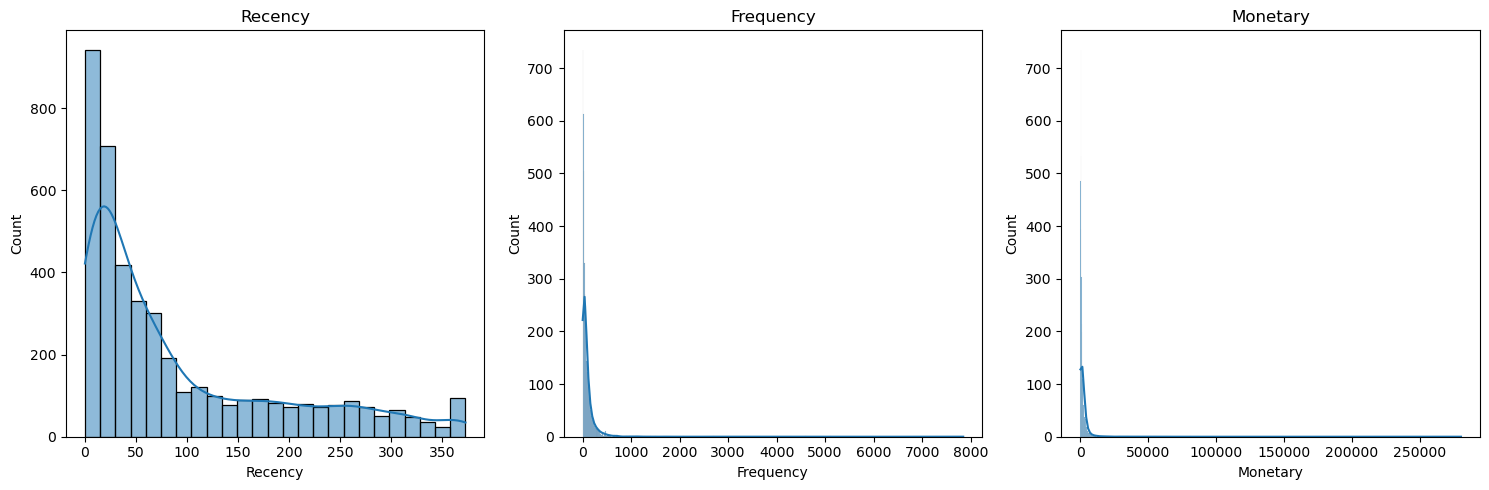

In [22]:
plt.figure(figsize=(15, 5))

# Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'],kde=True)
plt.title('Recency')

# Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'],kde=True)
plt.title('Frequency')

# Monetary
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'],kde=True)
plt.title('Monetary')

plt.tight_layout()
plt.show()

In [23]:
def remove_outliers_iqr(df, column):
    return df[df[column] <= df[column].quantile(0.95)]

# Apply the function to remove outliers for each column
rfm = remove_outliers_iqr(rfm, 'Frequency')
rfm= remove_outliers_iqr(rfm, 'Monetary')
rfm = remove_outliers_iqr(rfm, 'Recency')

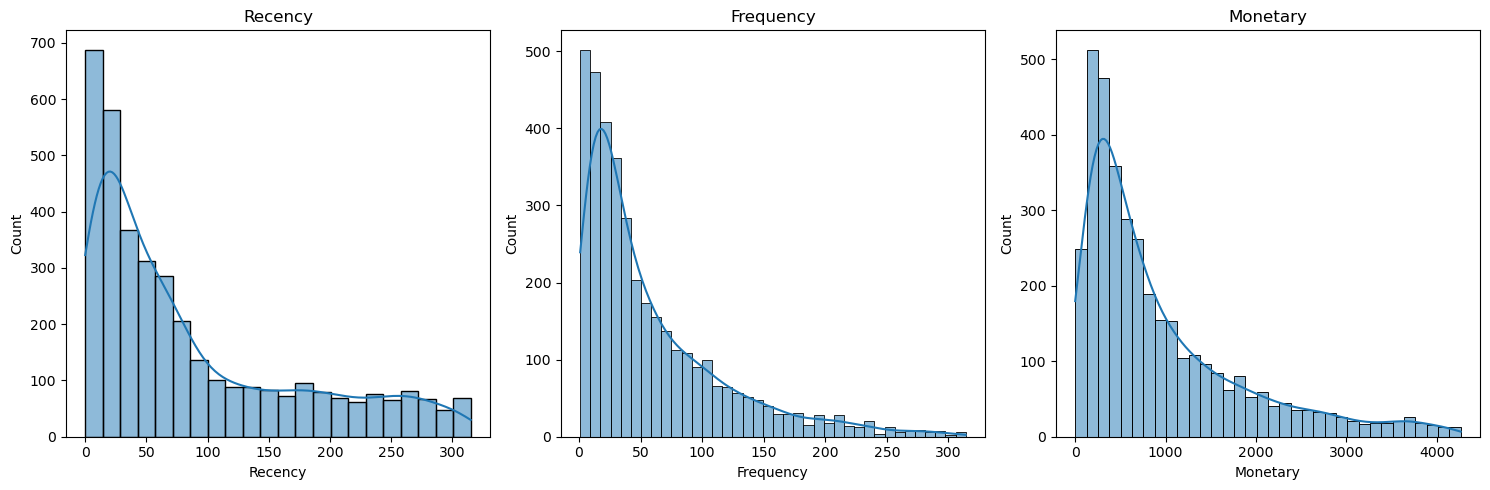

In [24]:
plt.figure(figsize=(15, 5))

# Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'],kde=True)
plt.title('Recency')

# Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'],kde=True)
plt.title('Frequency')

# Monetary
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'],kde=True)
plt.title('Monetary')

plt.tight_layout()
plt.show()

# Clustering

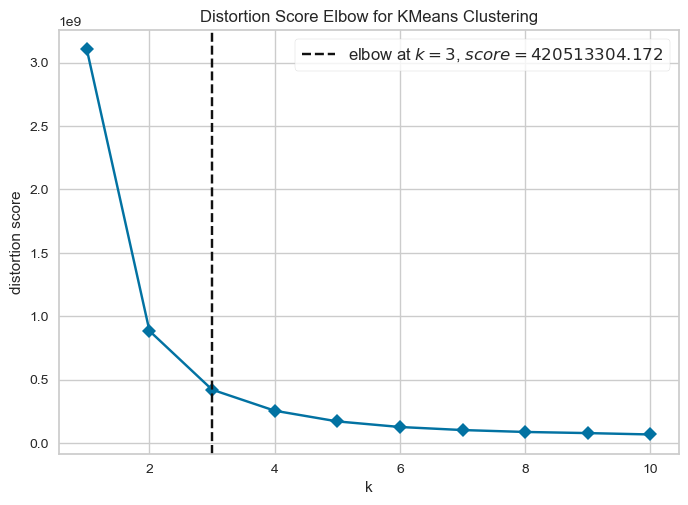

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
from sklearn.cluster import KMeans
model = KMeans()

from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(rfm)        
visualizer.show()

In [27]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(rfm)
rfm['Clusters']= y_predicted
rfm.head()

,Recency,Frequency,Monetary,Clusters
2,74,31,1797.24,0
3,18,73,1757.55,0
4,309,17,334.40,1
5,35,85,2506.04,2
6,203,4,89.00,1


In [28]:
from sklearn.metrics import silhouette_score

# Extract features
X =rfm[['Recency', 'Frequency', 'Monetary']]
labels = rfm['Clusters']

# Calculate silhouette score
score = silhouette_score(X, labels, metric='euclidean')
print(f'Silhouette Score: {score}')

Silhouette Score: 0.6141220183088014


# Cluster Visualization & Analysis

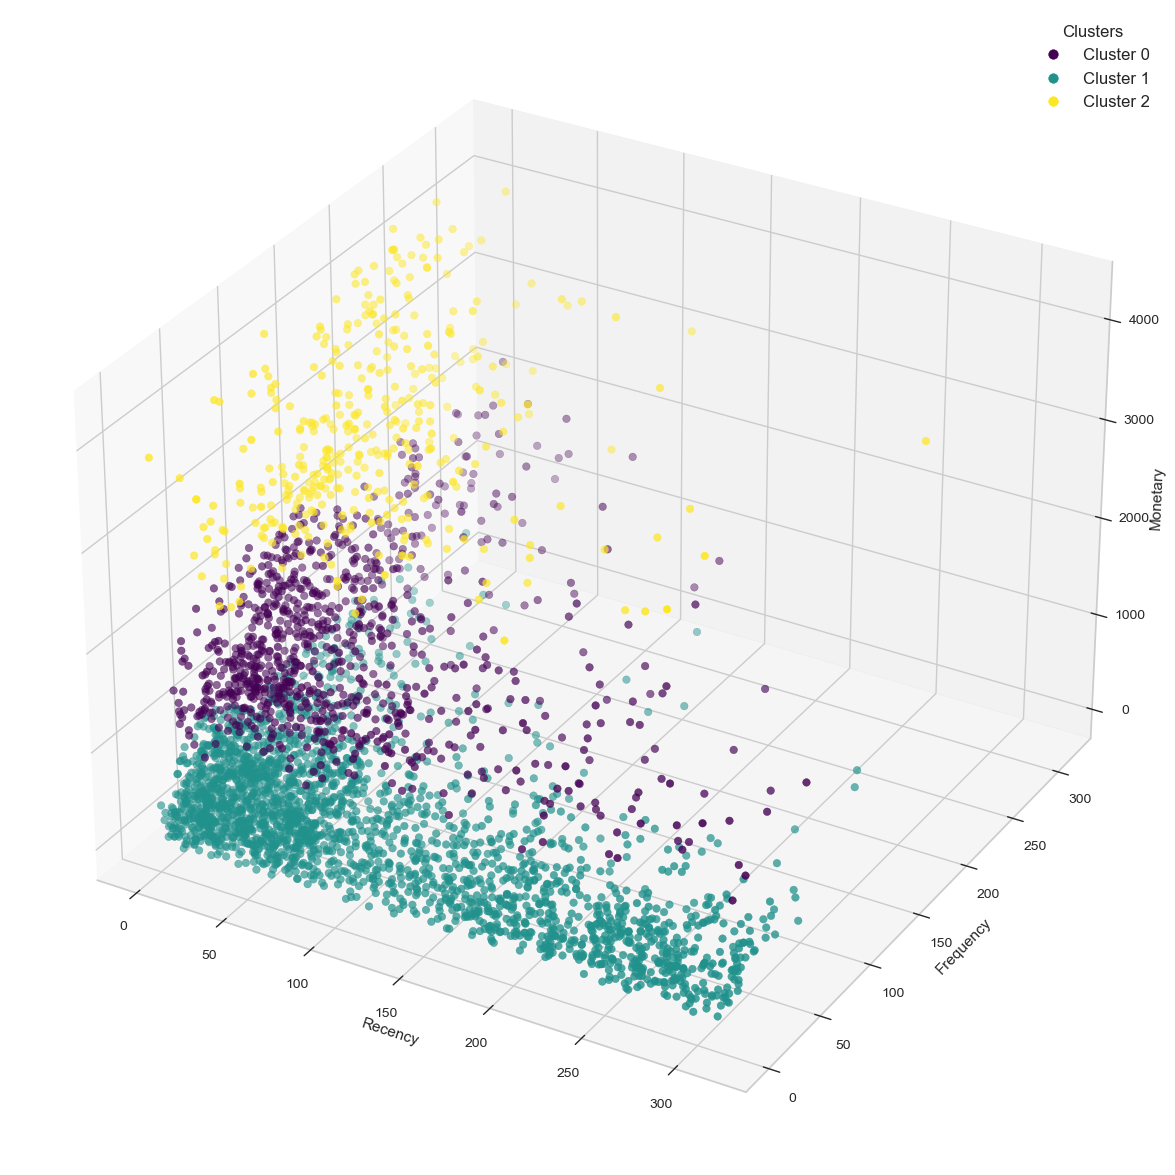

In [30]:
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D scatter plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],cmap='viridis', c=rfm['Clusters'],s=30)

# Add labels
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

handles, labels = scatter.legend_elements()
legend = ax.legend(handles, [f"Cluster {int(label)}" for label in rfm['Clusters'].unique()],
                   title="Clusters", loc="best", fontsize=12)
plt.show()

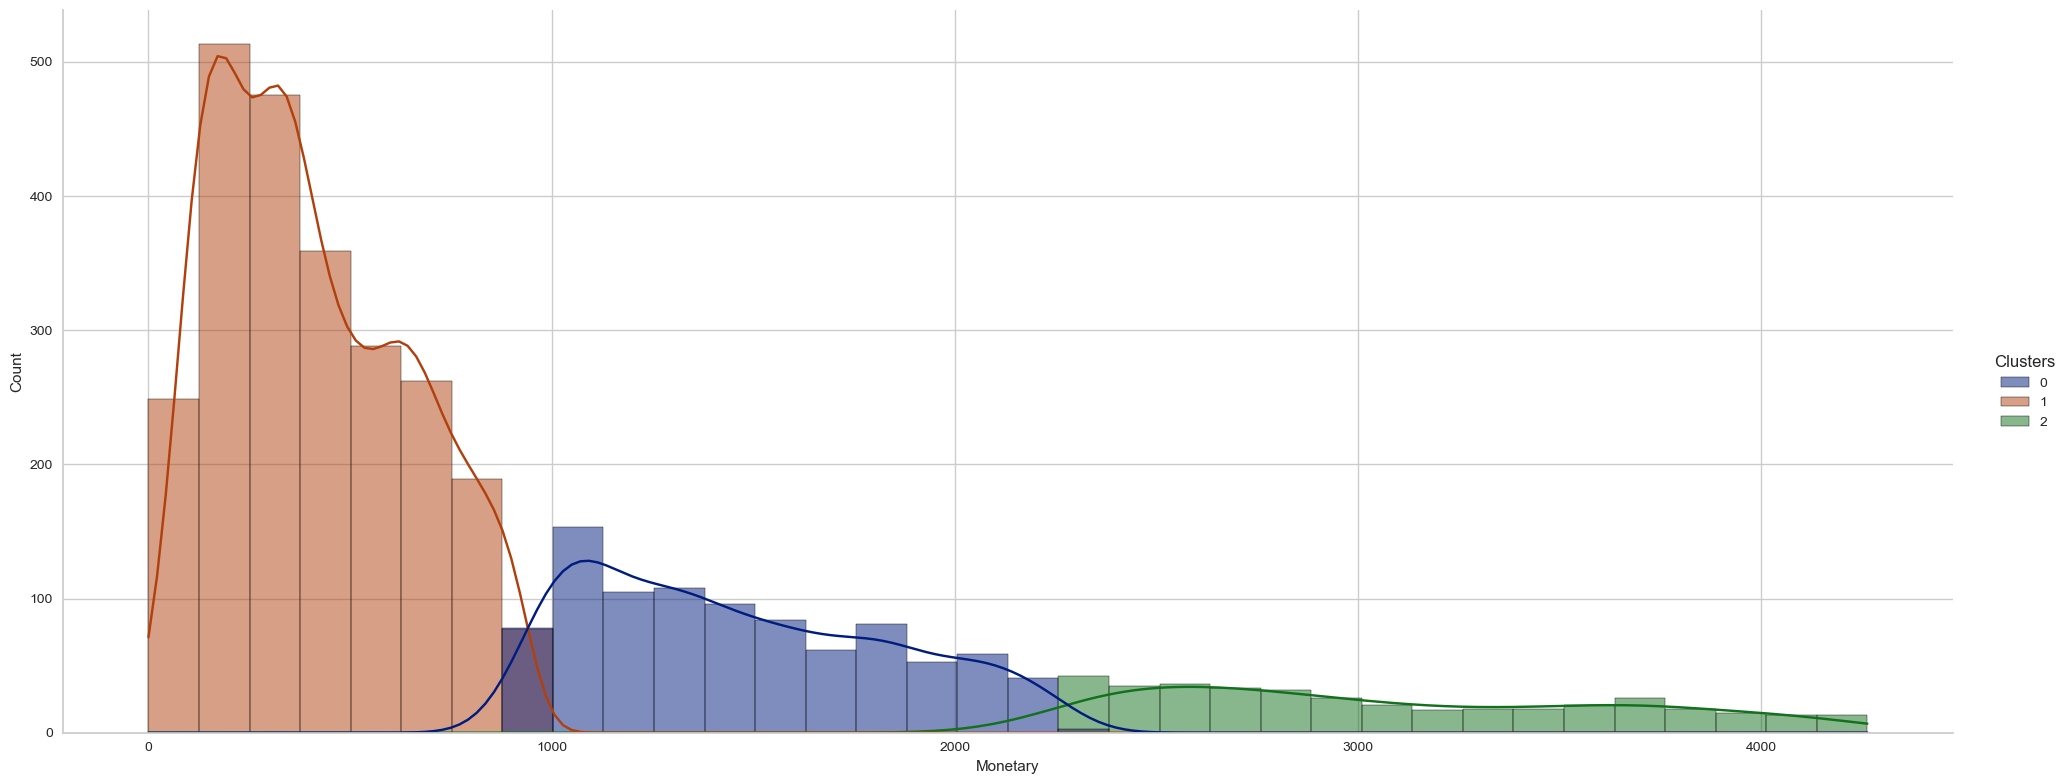

In [31]:
sns.displot(rfm, x='Monetary', hue='Clusters', kde=True, height=8, aspect=2.5, palette="dark")

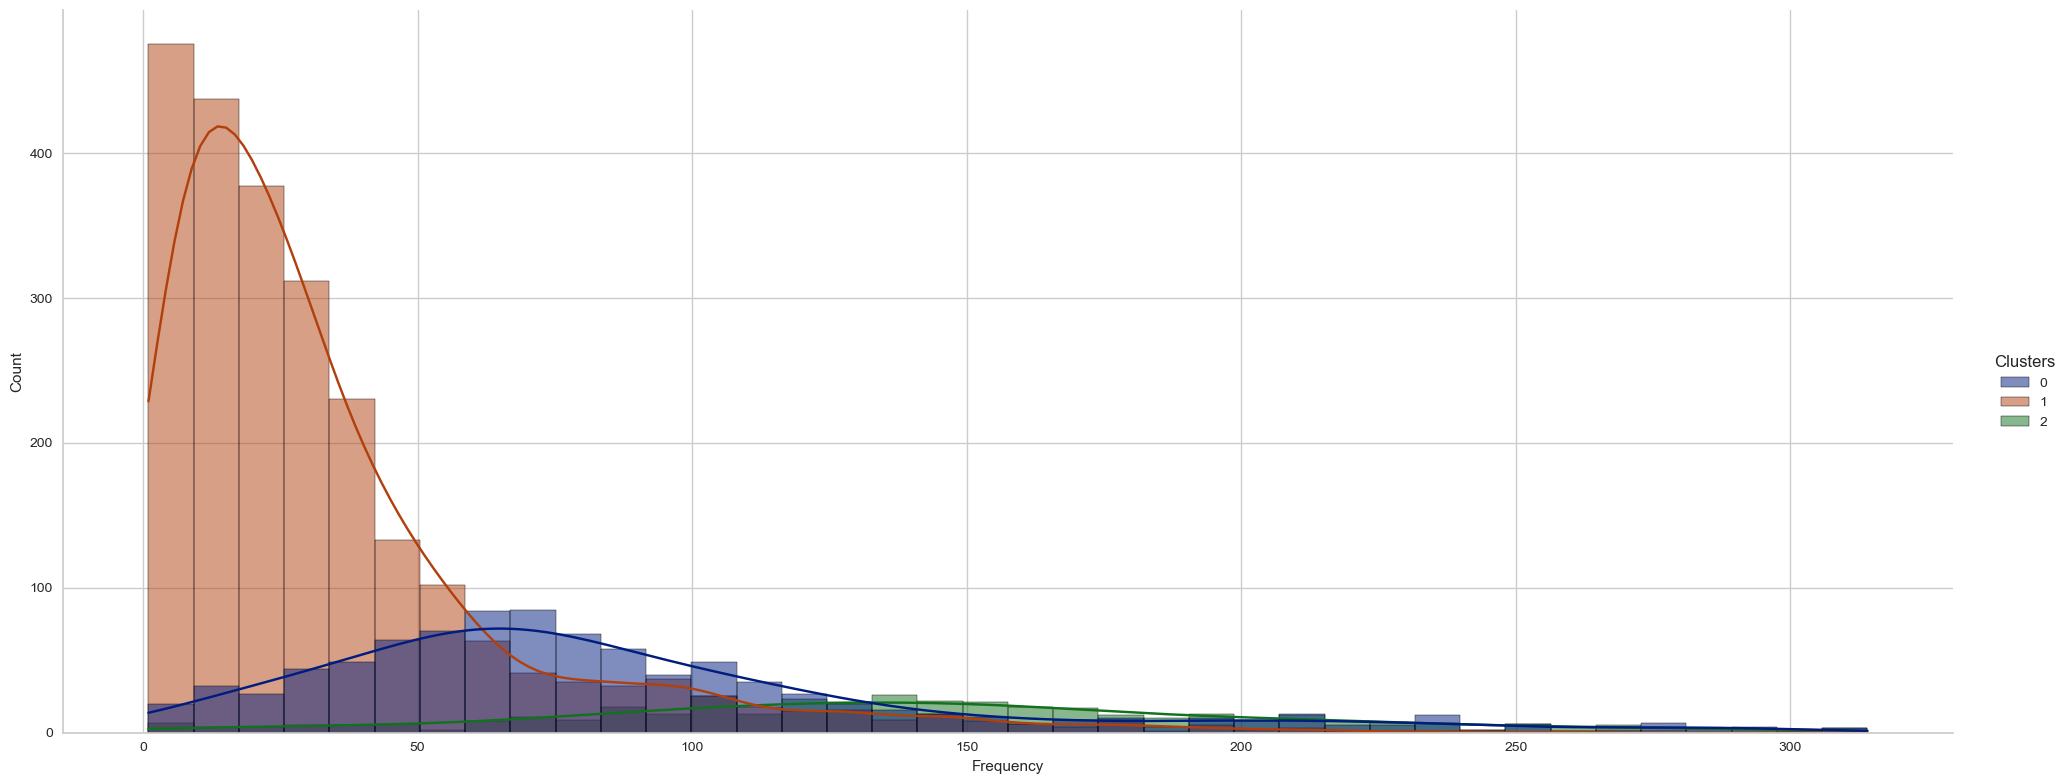

In [32]:
sns.displot(rfm, x='Frequency', hue='Clusters', kde=True,  height=8, aspect=2.5, palette="dark")

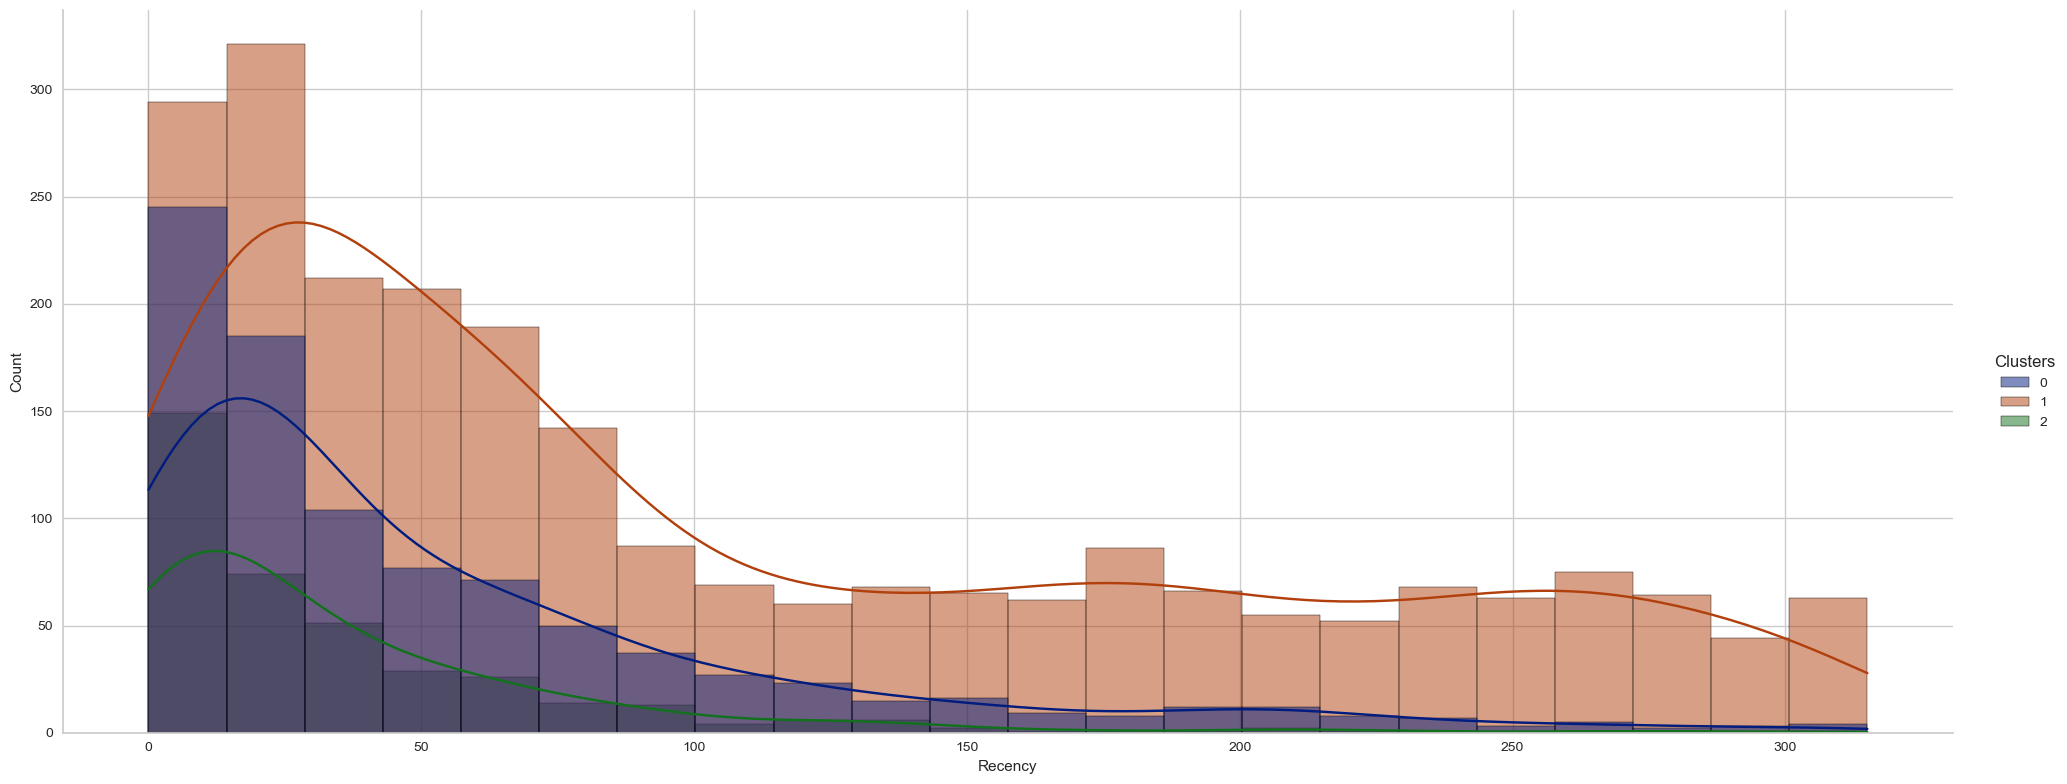

In [33]:
sns.displot(rfm, x='Recency', hue='Clusters', kde=True,  height=8, aspect=2.5,  palette="dark")

In [34]:

rfm.groupby('Clusters').describe()

Recency                                                          \
           count        mean        std  min    25%   50%     75%    max   
Clusters                                                                   
0          923.0   54.885157  61.039138  0.0  14.00  31.0   74.00  315.0   
1         2412.0  105.567579  91.996921  0.0  28.00  71.0  177.00  315.0   
2          384.0   36.580729  45.111799  0.0   7.75  22.0   50.25  305.0   

         Frequency              ...               Monetary               \
             count        mean  ...    75%    max    count         mean   
Clusters                        ...                                       
0            923.0   88.365114  ...  109.0  314.0    923.0  1462.210076   
1           2412.0   33.567579  ...   42.0  258.0   2412.0   409.910267   
2            384.0  142.028646  ...  180.0  314.0    384.0  3072.970706   

                                                                       
                 std      min        25%       50%       75%      max  
Clusters                                                               
0         373.098201   933.62  1128.4250  1390.500  1766.115  2265.12  
1         237.333775     0.00   208.2200   364.550   599.170   944.10  
2         569.102842  2272.40  2597.5475  2958.045  3569.395  4263.64  

[3 rows x 24 columns]

# observation & Insight

In [36]:
'''
Based on the data and feature ranges you've provided for each cluster, you can develop targeted marketing strategies for each customer segment. Here’s a potential marketing strategy for each cluster:

### 1. **Cluster 0**

- **Recency**: 0 - 315 days (average: 105.5 days)
- **Frequency**: 1 - 258 purchases (average: 33.6 purchases)
- **Monetary**: $0.00 - $944.10 (average: $410.13)

#### Strategy:
- **Target**: This cluster has a wide range of recency, suggesting a mix of very recent and somewhat older customers. They have low to moderate frequency and monetary values.
- **Engagement**: Implement re-engagement campaigns to bring back inactive customers, especially those with high recency but low frequency.
- **Offers**: Offer discounts or incentives for frequent purchases to boost customer loyalty and increase purchase frequency.
- **Personalization**: Use data to personalize offers based on purchase history. Highlight products that have been purchased previously or related items.

### 2. **Cluster 1**

- **Recency**: 0 - 305 days (average: 36.7 days)
- **Frequency**: 1 - 314 purchases (average: 142.3 purchases)
- **Monetary**: $2273.68 - $4263.64 (average: $3077.16)

#### Strategy:
- **Target**: This cluster consists of recent customers with high frequency and high monetary value.
- **Loyalty Programs**: Reward these high-value customers with loyalty programs or exclusive offers to maintain their high engagement.
- **Upselling and Cross-selling**: Introduce premium or complementary products to further increase their average spending.
- **Feedback and Advocacy**: Engage with these customers to gather feedback and encourage them to become brand advocates.

### 3. **Cluster 2**

- **Recency**: 0 - 315 days (average: 54.9 days)
- **Frequency**: 1 - 314 purchases (average: 88.4 purchases)
- **Monetary**: $933.62 - $2273.18 (average: $1464.54)

#### Strategy:
- **Target**: This cluster has moderate recency, frequency, and monetary values.
- **Retention Campaigns**: Focus on retention strategies such as personalized emails or special promotions to encourage repeat purchases.
- **Segmentation**: Segment this group further based on their purchase history to deliver more targeted offers.
- **Seasonal Promotions**: Use seasonal or limited-time offers to increase engagement and drive additional purchases.

### General Recommendations:

1. **Data-Driven Personalization**: Use the data to create personalized marketing campaigns that cater to the specific behaviors and preferences of each cluster.
2. **Customer Feedback**: Collect feedback from each segment to understand their needs better and adjust marketing strategies accordingly.
3. **Track Performance**: Continuously monitor the effectiveness of marketing strategies for each cluster and adjust as needed based on performance metrics.

By tailoring your marketing strategies to the characteristics of each cluster, you can more effectively target and engage with different segments of your customer base.
'''

"\nBased on the data and feature ranges you've provided for each cluster, you can develop targeted marketing strategies for each customer segment. Here’s a potential marketing strategy for each cluster:\n\n### 1. **Cluster 0**\n\n- **Recency**: 0 - 315 days (average: 105.5 days)\n- **Frequency**: 1 - 258 purchases (average: 33.6 purchases)\n- **Monetary**: $0.00 - $944.10 (average: $410.13)\n\n#### Strategy:\n- **Target**: This cluster has a wide range of recency, suggesting a mix of very recent and somewhat older customers. They have low to moderate frequency and monetary values.\n- **Engagement**: Implement re-engagement campaigns to bring back inactive customers, especially those with high recency but low frequency.\n- **Offers**: Offer discounts or incentives for frequent purchases to boost customer loyalty and increase purchase frequency.\n- **Personalization**: Use data to personalize offers based on purchase history. Highlight products that have been purchased previously or rela